In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [132]:
df=pd.read_csv('data/checkoutstimeseries.csv',parse_dates=['Year-Month'])
df.head()


,Unnamed: 0,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
0,0,2005-04-01,143053,0,37432,32157,0,40021
1,1,2005-05-01,227864,0,58138,53305,0,62088
2,2,2005-06-01,287908,0,70580,67821,0,76130
3,3,2005-07-01,195018,0,49752,48457,0,50441
4,4,2005-08-01,210033,0,55664,53192,0,54818


In [133]:
df.columns

Index(['Unnamed: 0', 'Year-Month', 'BOOK', 'EBOOK', 'SOUNDDISC', 'VIDEODISC',
       'AUDIOBOOK', 'Other'],
      dtype='object')

In [134]:
#We don't need the first column, so we drop it.
df = df.drop('Unnamed: 0', axis=1)


In [135]:
df.head()

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
0,2005-04-01,143053,0,37432,32157,0,40021
1,2005-05-01,227864,0,58138,53305,0,62088
2,2005-06-01,287908,0,70580,67821,0,76130
3,2005-07-01,195018,0,49752,48457,0,50441
4,2005-08-01,210033,0,55664,53192,0,54818


In [136]:
#Our data is unreliable after April of 2024, so we drop the rows after this.

df = df.drop(df[df['Year-Month'] > pd.to_datetime('2024-04-01') ].index)

In [137]:
df.tail()

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
224,2023-12-01,218063,271133,14063,46244,220101,8465
225,2024-01-01,249991,286052,14163,48465,241287,9470
226,2024-02-01,227572,257818,14385,45266,218335,9008
227,2024-03-01,240492,269650,14148,47753,232102,9279
228,2024-04-01,232015,258261,13424,44527,221409,9053


In [138]:
#Make our test-train-split
df_train=df[df['Year-Month']< pd.to_datetime('2023-05-01')]
df_test=df[df['Year-Month']>= pd.to_datetime('2023-05-01')]

In [139]:
df_test.head(13)

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
217,2023-05-01,234008,245842,13735,42223,199974,7133
218,2023-06-01,243120,244555,13883,42370,201215,7520
219,2023-07-01,254000,264058,13274,42414,212350,7989
220,2023-08-01,259623,262905,14209,44633,217048,8623
221,2023-09-01,239205,252549,12838,42896,208961,8168
222,2023-10-01,242487,260825,12756,44176,216269,8671
223,2023-11-01,229088,255659,12904,42698,211135,8650
224,2023-12-01,218063,271133,14063,46244,220101,8465
225,2024-01-01,249991,286052,14163,48465,241287,9470
226,2024-02-01,227572,257818,14385,45266,218335,9008


Now, we want to some time series forecasting.

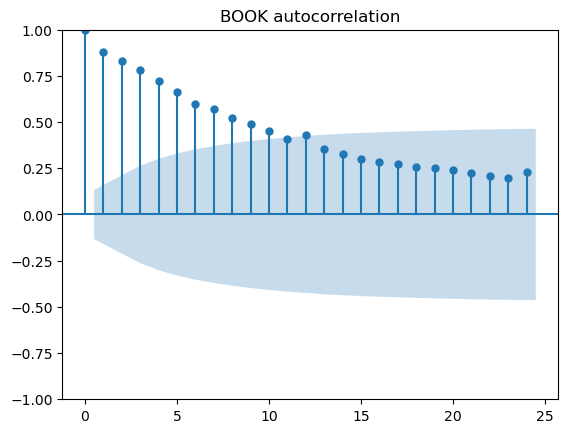

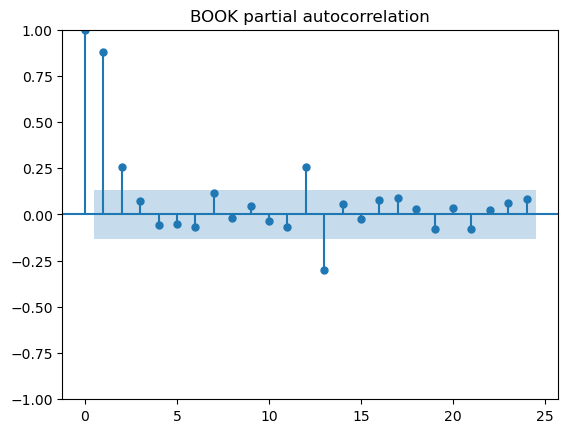

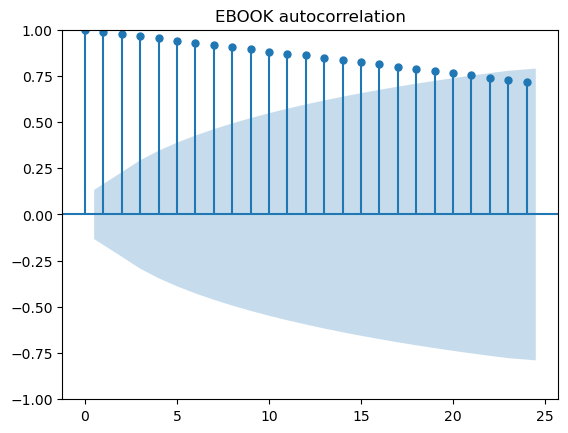

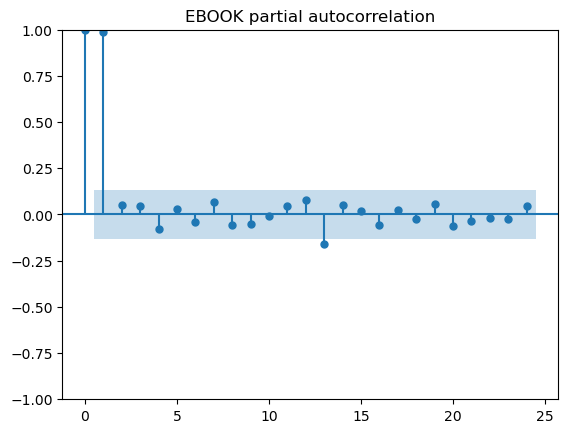

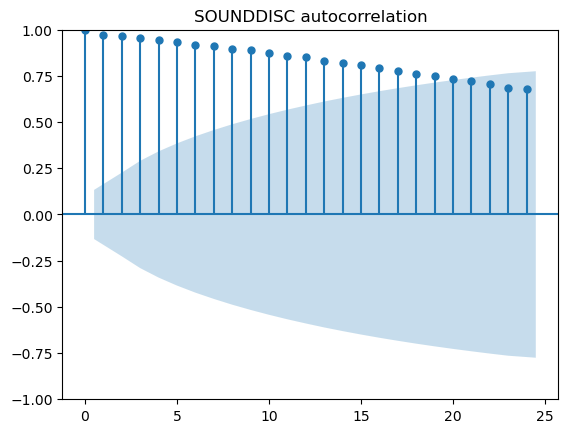

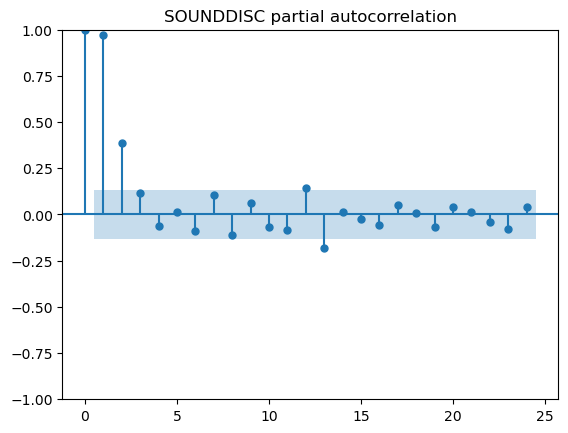

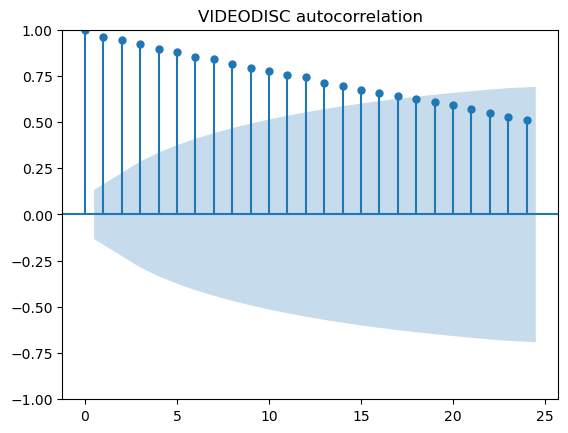

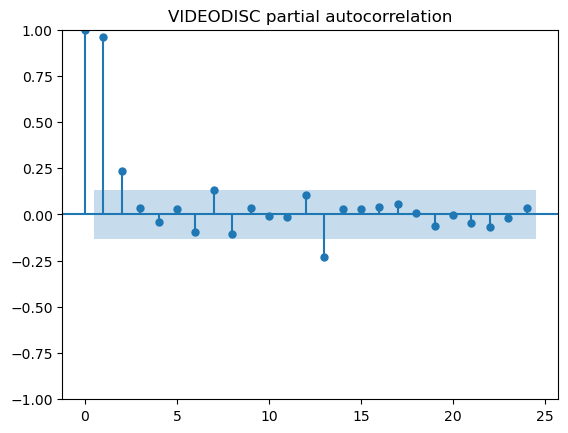

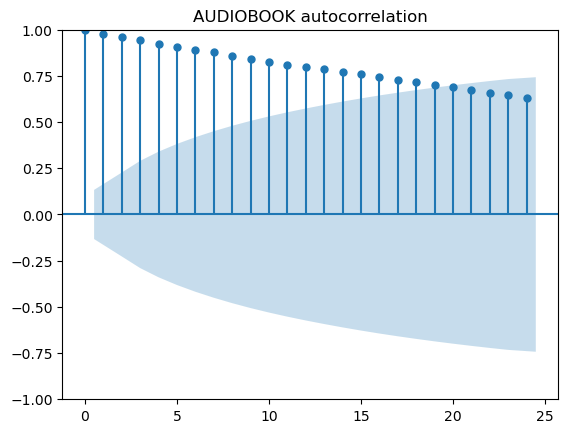

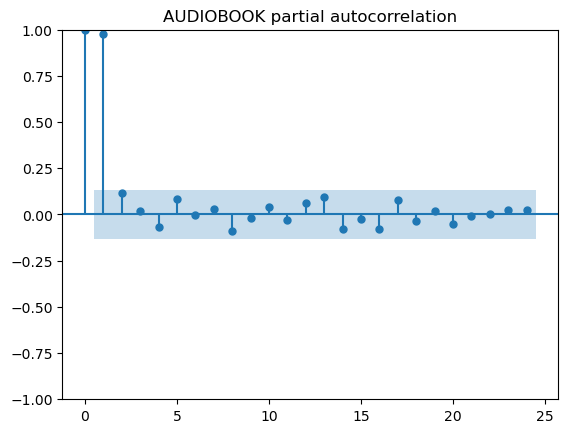

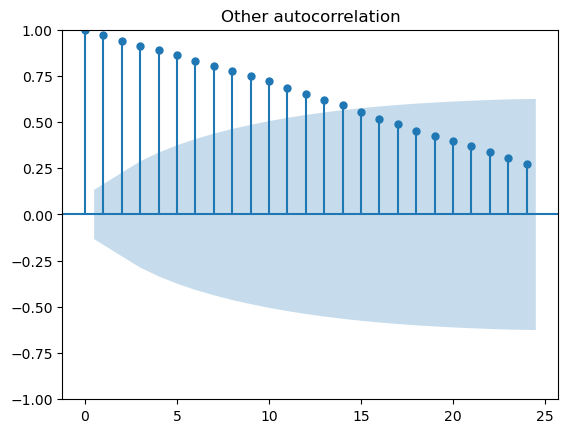

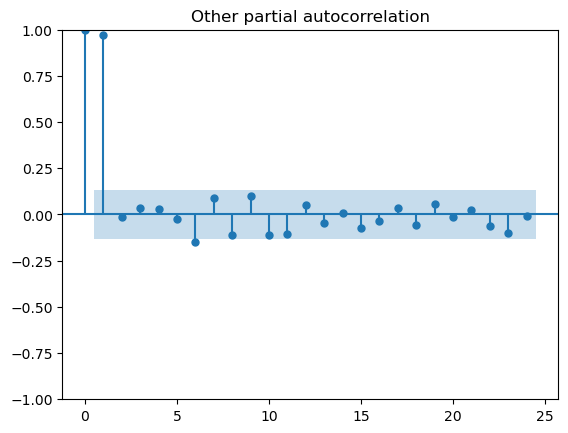

In [140]:
#Let's see how much autocorrelation there is

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#get list of materials forecast for
materials=['BOOK','EBOOK','SOUNDDISC','VIDEODISC','AUDIOBOOK','Other']

for x in materials:
    plot_acf(df_train[x])
    plt.title(x + ' autocorrelation')
    plot_pacf(df_train[x])
    plt.title(x + ' partial autocorrelation')
    plt.show


It looks like some of the plots may have some 12 month seasonality based on the peaks in PACF, but the effect doesn't appear very strong. Let's look at some pictures to get a sense of the overall trends.

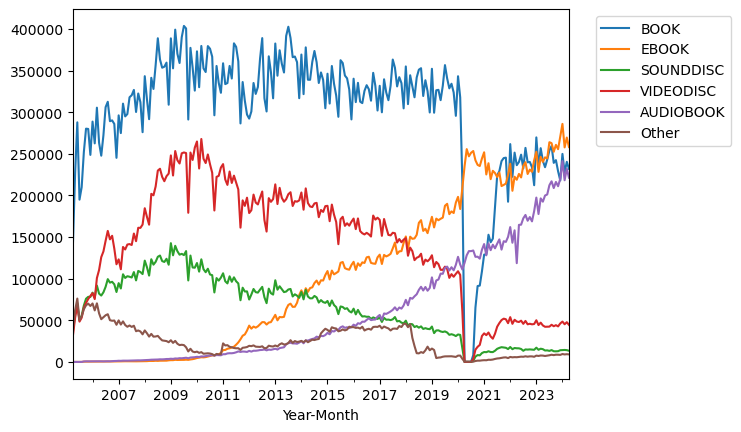

In [141]:


df.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'])

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

It looks like there is a linar trend in books, videodiscs, sound discs, and ebooks, and an exponential trend in audiobooks. I don't see any seasonality in these plots, but that could be lost in the overall trend. 

Before doing forecasting, I will try to substract out some trends.

I'll fit a spline model to account for the trend. I want to set the knots to be around the pandemic.



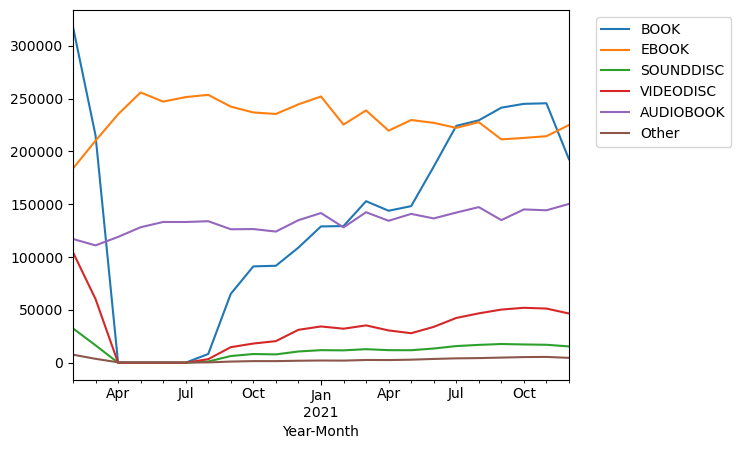

In [142]:
df_pandemicera=df_train[(df_train['Year-Month']<pd.to_datetime('2022-01-01')) & (df_train['Year-Month']>pd.to_datetime('2020-01-01'))]

df_pandemicera.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'])

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

In [143]:
#get the indices of April, July and October 2020

df_pandemicera.head(10)

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
178,2020-02-01,317946,183789,32491,104503,117082,7620
179,2020-03-01,215128,210061,16494,60309,111031,3692
180,2020-04-01,70,235051,5,5,119039,402
181,2020-05-01,87,255745,1,3,128189,268
182,2020-06-01,43,247083,0,4,133186,246
183,2020-07-01,52,251359,2,12,133161,213
184,2020-08-01,8276,253472,1155,3374,133910,316
185,2020-09-01,65204,242337,6332,14705,126290,1093
186,2020-10-01,91168,236818,8236,18152,126477,1522
187,2020-11-01,91740,235396,7876,20432,124111,1516


In [144]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression

In [145]:
trendpipeline=Pipeline([('spline',SplineTransformer(knots=np.array([0,30, 60, 90, 120, 150,180,183,186,216]).reshape(-1,1), degree=3, extrapolation='linear')),
                        ('regression',LinearRegression())])

In [146]:
#make a pandas dataframe  to store the trend 
df_train_trend=df_train.__deepcopy__()

for feature in materials:
    trendpipeline.fit(X=np.array(df_train.index).reshape(-1,1),y=df_train[feature])
    prediction=trendpipeline.predict(X=np.array(df_train.index).reshape(-1,1))
    df_train_trend[feature]=prediction


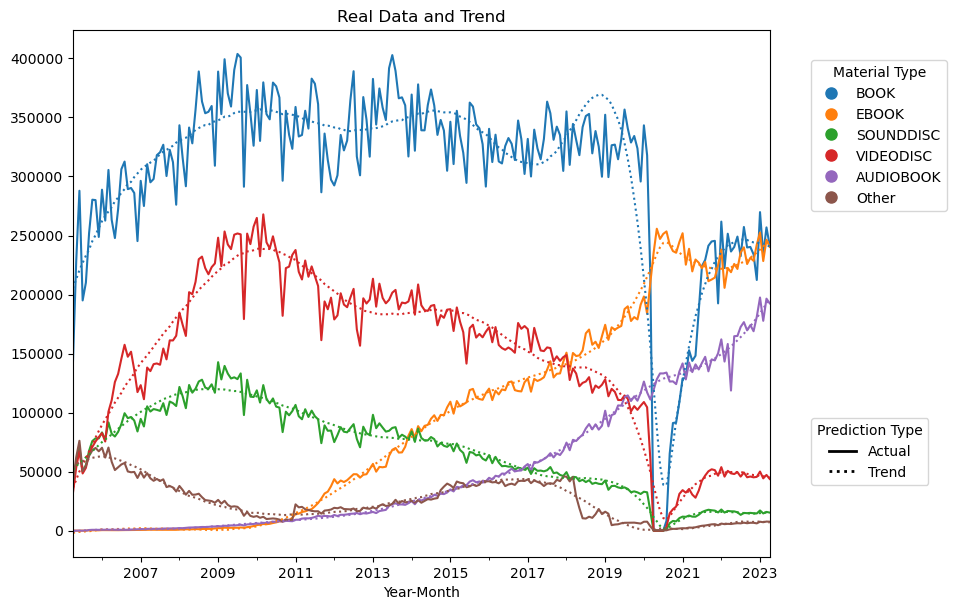

In [147]:
#plot both the raw data and the trend.

# Define corresponding colors for materials
colors = dict(zip(materials, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']))

# Define linestyles for different prediction types
linestyles = {'Actual': '-', 'Trend': ':'}

fig, ax = plt.subplots(figsize=(12, 6))
df_train.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'], color=colors, ls=linestyles['Actual'], ax=ax)
df_train_trend.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'], color=colors, ls=linestyles['Trend'], ax=ax)

# Create custom legends
color_handles = [Line2D([0], [0], color=color, marker='o', markersize=8, linestyle='None') for color in colors.values()]
linestyle_handles = [Line2D([0], [0], color='black', linestyle=style, lw=2) for style in linestyles.values()]

# Add legends outside the plot
color_legend = ax.legend(handles=color_handles, labels=materials, title='Material Type', loc='center left', bbox_to_anchor=(1.05, 0.8))
ax.add_artist(color_legend)  # Add material type legend first
linestyle_legend = ax.legend(handles=linestyle_handles, labels=linestyles.keys(), title='Prediction Type', loc='center left', bbox_to_anchor=(1.05, 0.2))

# Adjust layout to make room for legends
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Reserve space for the legends on the right
plt.title('Real Data and Trend')
plt.show()

Now, we subtract the trend and examine the resulting plot.

<Figure size 1000x500 with 0 Axes>

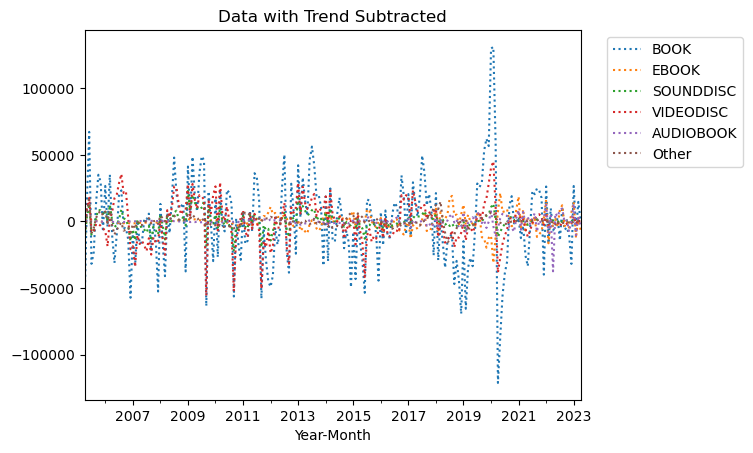

In [148]:
#subtract the trend.

df_train_no_trend=df_train.__deepcopy__()

for feature in materials:
    df_train_no_trend[feature]=df_train[feature]-df_train_trend[feature]

plt.figure(figsize=(10,5))

df_train_no_trend.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'], ls=":")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title('Data with Trend Subtracted')
plt.show()


Before we do our modeling, we plot the ACFS and PACFS with the trend subtracted.

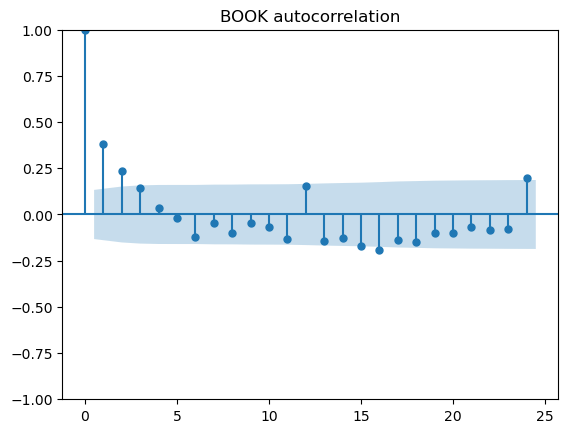

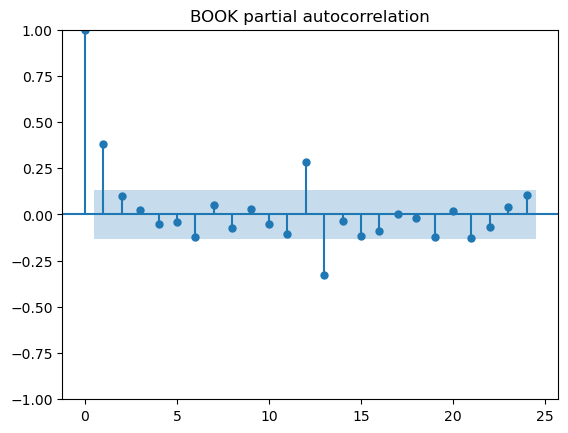

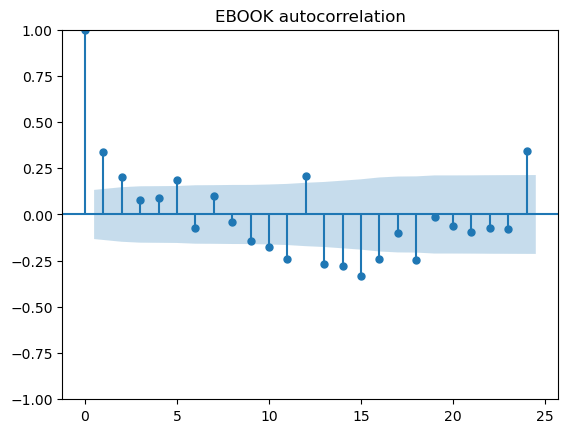

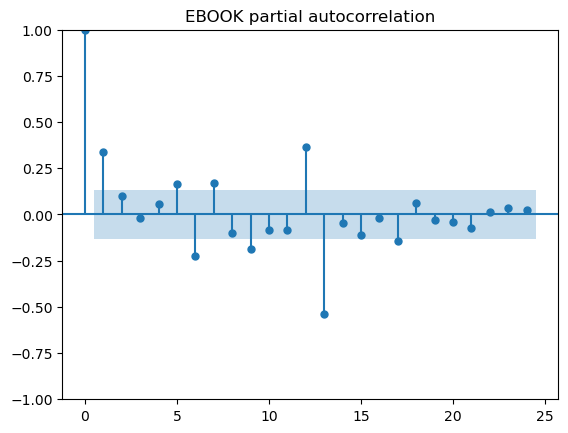

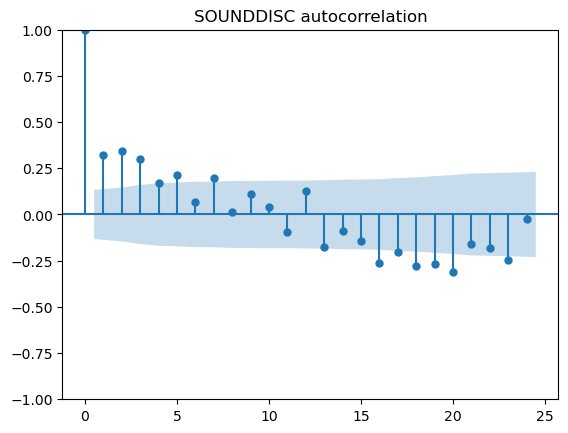

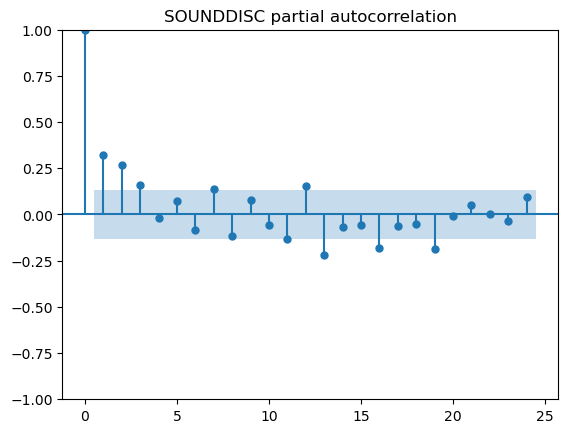

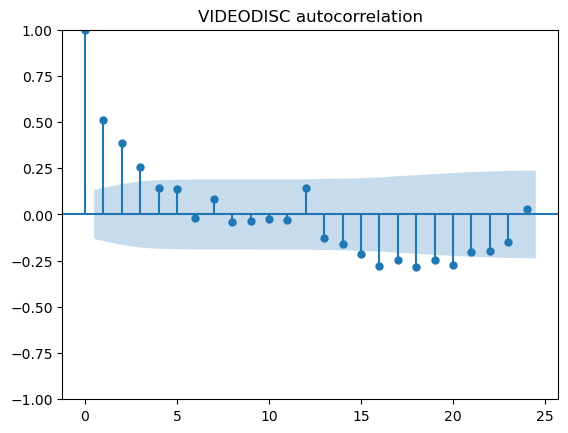

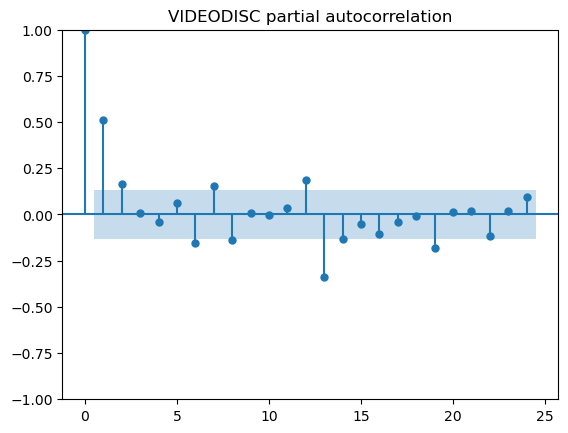

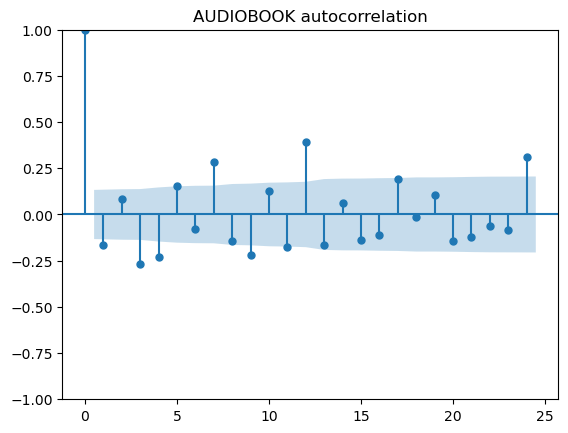

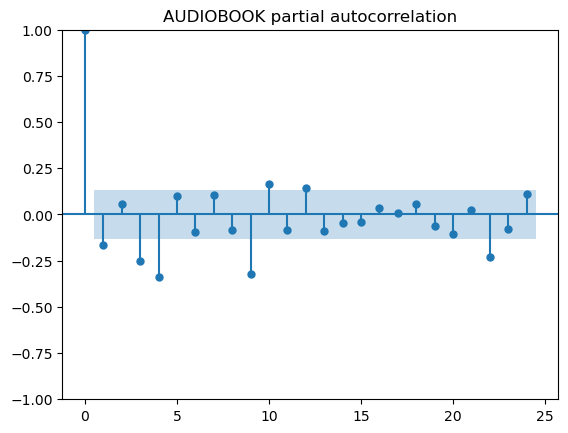

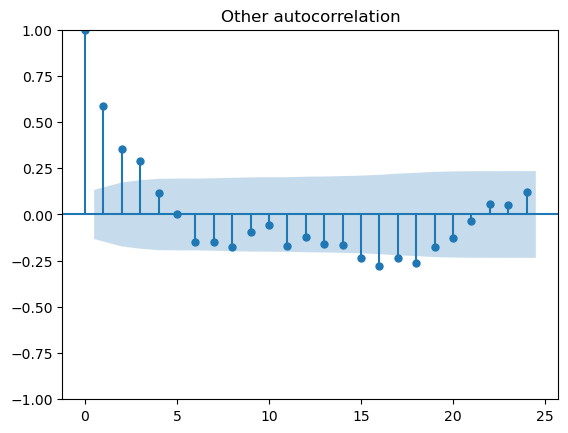

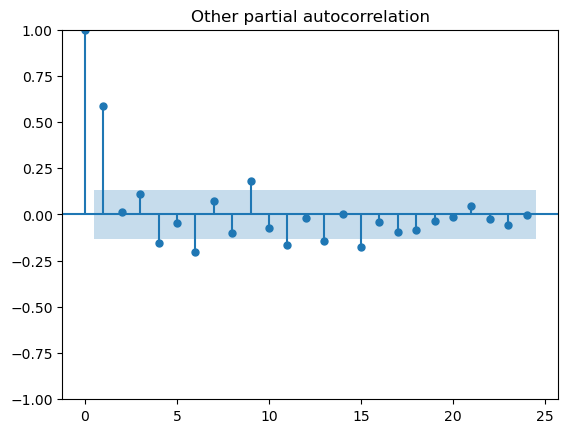

In [149]:
for x in materials:
    plot_acf(df_train_no_trend[x])
    plt.title(x + ' autocorrelation')
    plot_pacf(df_train_no_trend[x])
    plt.title(x + ' partial autocorrelation')
    plt.show

We see that in most categories the PACF have bigger spikes at 12 and 13 months.

Now, we do some modeling with ARIMA. First, we make our cross validation splits.

In [150]:
from sklearn.model_selection import TimeSeriesSplit

In [151]:
tscv=TimeSeriesSplit(n_splits=12, test_size=1)



Our Naive model will be linear regression. We will also use AutoArima, and Autoarima on the data with the trend taken out (then added back) and seasonality set to 12.

In [152]:
import pmdarima as pm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_percentage_error as mape

In [153]:
baseline_linear=LinearRegression()


In [154]:
#make 3 dataframe for predictions
df_baseline_preds=pd.DataFrame(index=df.index, columns=materials)

df_autoarima_preds=pd.DataFrame(index=df.index, columns=materials)

df_autoarima_no_trend_withseasonality_preds=pd.DataFrame(index=df.index, columns=materials)




In [155]:

for train_index, test_index in tscv.split(df_train):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    # print(test_index)
    for feature in materials:
        #fit the three models
        baseline_linear.fit(X=np.array(train_index).reshape(-1,1),y=df_tt[feature])
        autoarima=pm.auto_arima(df_tt[feature],error_action='ignore')
        print(test_index, "auto arima model for", feature, autoarima.get_params() )
        trendpipeline.fit(X=np.array(train_index).reshape(-1,1),y=df_tt[feature])
        prediction_of_trend=trendpipeline.predict(X=np.array(train_index).reshape(-1,1))
        data_without_trend=df_tt[feature]-prediction_of_trend
        autoarima_no_trend_with_seasonality=pm.auto_arima(data_without_trend,seasonal=True, m=12, error_action='ignore', stationary=True)
        #the m parameter in autoarima controls seasonality.
        print(test_index, "auto arima with seasonality model for", feature,  autoarima_no_trend_with_seasonality.get_params() )
        df_baseline_preds.loc[test_index,feature]=baseline_linear.predict(X=np.array(test_index).reshape(-1,1))
        df_autoarima_preds.loc[test_index,feature]=autoarima.predict(n_periods=1)
        df_autoarima_no_trend_withseasonality_preds.loc[test_index,feature]=autoarima_no_trend_with_seasonality.predict(n_periods=1)+trendpipeline.predict(X=np.array(test_index).reshape(-1,1))

[205] auto arima model for BOOK {'maxiter': 50, 'method': 'lbfgs', 'order': (1, 1, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}
[205] auto arima with seasonality model for BOOK {'maxiter': 50, 'method': 'lbfgs', 'order': (1, 0, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (1, 0, 1, 12), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}
[205] auto arima model for EBOOK {'maxiter': 50, 'method': 'lbfgs', 'order': (1, 1, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}
[205] auto arima with seasonality model for EBOOK {'maxiter': 50, 'method': 'lbfgs', 'order': (1, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, '

In [156]:


df_baseline_preds['Year-Month']=df['Year-Month']
df_autoarima_preds['Year-Month']=df['Year-Month']
df_autoarima_no_trend_withseasonality_preds['Year-Month']=df['Year-Month']

# df_autoarima_no_trend_withseasonality_preds.head()

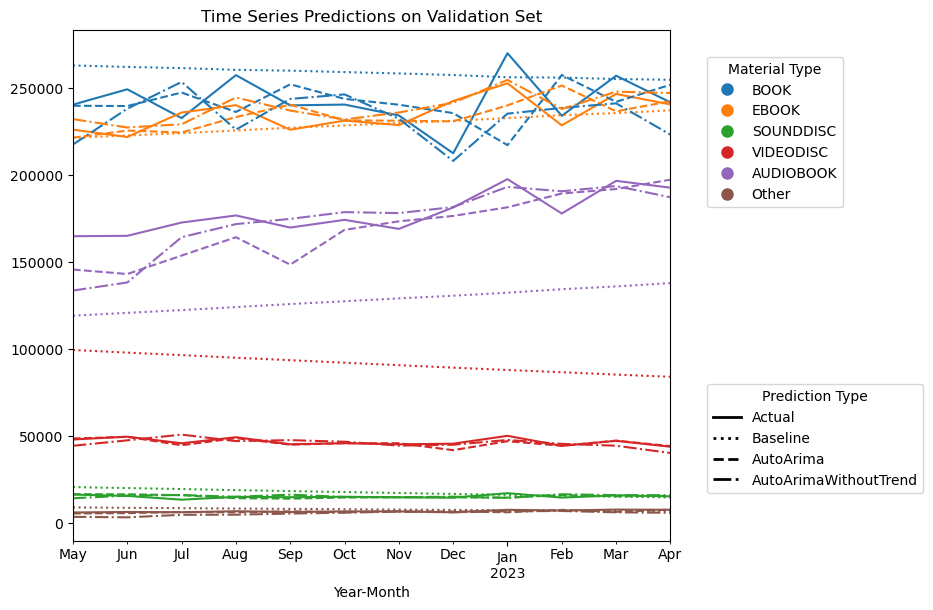

In [157]:
from matplotlib.lines import Line2D

df_train_end = df_train.iloc[205:217]
df_baseline_preds_end = df_baseline_preds.iloc[205:217]
df_autoarima_preds_end = df_autoarima_preds.iloc[205:217]
df_autoarima_no_trend_withseasonality_preds_end = df_autoarima_no_trend_withseasonality_preds.iloc[205:217]


# Define corresponding colors for materials
colors = dict(zip(materials, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']))

# Define linestyles for different prediction types
linestyles = {'Actual': '-', 'Baseline': ':', 'AutoArima': '--', 'AutoArimaWithoutTrend': '-.'}

# Plot predictions with whole time series
fig, ax = plt.subplots(figsize=(12, 6))
df_train_end.plot(x='Year-Month', y=materials, color=colors, ax=ax)
df_baseline_preds_end.plot(x='Year-Month', y=materials, ls=linestyles['Baseline'], color=colors, ax=ax)
df_autoarima_preds_end.plot(x='Year-Month', y=materials, ls=linestyles['AutoArima'], color=colors, ax=ax)
df_autoarima_no_trend_withseasonality_preds_end.plot(x='Year-Month', y=materials, ls=linestyles['AutoArimaWithoutTrend'], color=colors, ax=ax)

# Create custom legends
color_handles = [Line2D([0], [0], color=color, marker='o', markersize=8, linestyle='None') for color in colors.values()]
linestyle_handles = [Line2D([0], [0], color='black', linestyle=style, lw=2) for style in linestyles.values()]

# Add legends outside the plot
color_legend = ax.legend(handles=color_handles, labels=materials, title='Material Type', loc='center left', bbox_to_anchor=(1.05, 0.8))
ax.add_artist(color_legend)  # Add material type legend first
linestyle_legend = ax.legend(handles=linestyle_handles, labels=linestyles.keys(), title='Prediction Type', loc='center left', bbox_to_anchor=(1.05, 0.2))

# Adjust layout to make room for legends
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Reserve space for the legends on the right
plt.title('Time Series Predictions on Validation Set')
plt.show()


Now, we get errors for our models.

In [158]:
df_errors=pd.DataFrame(index=['Baseline RMSE', 'AutoArima RMSE', 'AutoArimawithoutTrend RMSE'], columns=materials)

In [159]:
#to do: refactor this to be a nested for loop over the models, instead of copying something 3 times
for feature in materials:
    df_errors.loc['Baseline RMSE',feature]=rmse(y_true=df_train.loc[205:216][feature], y_pred=df_baseline_preds.loc[205:216][feature])
    df_errors.loc['AutoArima RMSE',feature]=rmse(y_true=df_train.loc[205:216][feature], y_pred=df_autoarima_preds.loc[205:216][feature])
    df_errors.loc['AutoArimawithoutTrend RMSE',feature]=rmse(y_true=df_train.loc[205:216][feature], y_pred=df_autoarima_no_trend_withseasonality_preds.loc[205:216][feature])
    df_errors.loc['Baseline MAPE',feature]=mape(y_true=df_train.loc[205:216][feature], y_pred=df_baseline_preds.loc[205:216][feature])
    df_errors.loc['AutoArima MAPE',feature]=mape(y_true=df_train.loc[205:216][feature], y_pred=df_autoarima_preds.loc[205:216][feature])
    df_errors.loc['AutoArimawithoutTrend MAPE',feature]=mape(y_true=df_train.loc[205:216][feature], y_pred=df_autoarima_no_trend_withseasonality_preds.loc[205:216][feature])

In [160]:
df_errors.head(10)

,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
Baseline RMSE,21786.723688,9501.078326,3216.909852,45040.005636,50365.3569,1606.195251
AutoArima RMSE,20705.749966,10621.341565,1221.599528,1468.966489,13932.623535,685.33117
AutoArimawithoutTrend RMSE,18146.85092,6077.223529,1453.322263,2616.680462,13339.572916,1559.746241
Baseline MAPE,0.080167,0.030745,0.184153,0.962654,0.278838,0.211655
AutoArima MAPE,0.065118,0.036403,0.059609,0.018656,0.069619,0.07947
AutoArimawithoutTrend MAPE,0.058838,0.02226,0.069123,0.048841,0.056387,0.189952


It looks like the AutoArima with the trend removed is the best for Books, Ebooks, and Audiobooks, while Auto Arima is best for Soundisc, Videodisc, and Other. We know will run these models on the test set.

In [161]:
notrend_materials=['BOOK','EBOOK','AUDIOBOOK']
autoarima_materials=['SOUNDDISC','VIDEODISC','Other']

In [162]:
#make 3 dataframe for test predictions
df_test_preds=pd.DataFrame(index=df.index, columns=materials)


In [163]:
for train_index, test_index in tscv.split(df):
    df_tt = df.iloc[train_index]
    df_ho = df.iloc[test_index]
    # print(test_index)
    for feature in notrend_materials:
        #fit the  models
        trendpipeline.fit(X=np.array(train_index).reshape(-1,1),y=df_tt[feature])
        prediction_of_trend=trendpipeline.predict(X=np.array(train_index).reshape(-1,1))
        data_without_trend=df_tt[feature]-prediction_of_trend
        autoarima_no_trend_with_seasonality=pm.auto_arima(data_without_trend,seasonal=True, m=12, error_action='ignore', stationary=True)
        #the m parameter in autoarima controls seasonality.
        print(test_index, "auto arima with seasonality model for", feature,  autoarima_no_trend_with_seasonality.get_params() )
        df_test_preds.loc[test_index,feature]=autoarima_no_trend_with_seasonality.predict(n_periods=1)+trendpipeline.predict(X=np.array(test_index).reshape(-1,1))
    for feature in autoarima_materials:
        autoarima=pm.auto_arima(df_tt[feature],error_action='ignore')
        print(test_index, "auto arima model for", feature, autoarima.get_params() )
        df_test_preds.loc[test_index,feature]=autoarima.predict(n_periods=1)

        
        

[217] auto arima with seasonality model for BOOK {'maxiter': 50, 'method': 'lbfgs', 'order': (1, 0, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (1, 0, 1, 12), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}
[217] auto arima with seasonality model for EBOOK {'maxiter': 50, 'method': 'lbfgs', 'order': (1, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (1, 0, 2, 12), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}
[217] auto arima with seasonality model for AUDIOBOOK {'maxiter': 50, 'method': 'lbfgs', 'order': (1, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (1, 0, 2, 12), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}
[217] auto arima model for SOUNDDISC {'maxiter': 50, 'method': 'lbfgs', 'order': (1, 2, 2), 'out_of_sample_size': 0, 'scoring':

In [164]:
df_test_preds['Year-Month']=df['Year-Month']

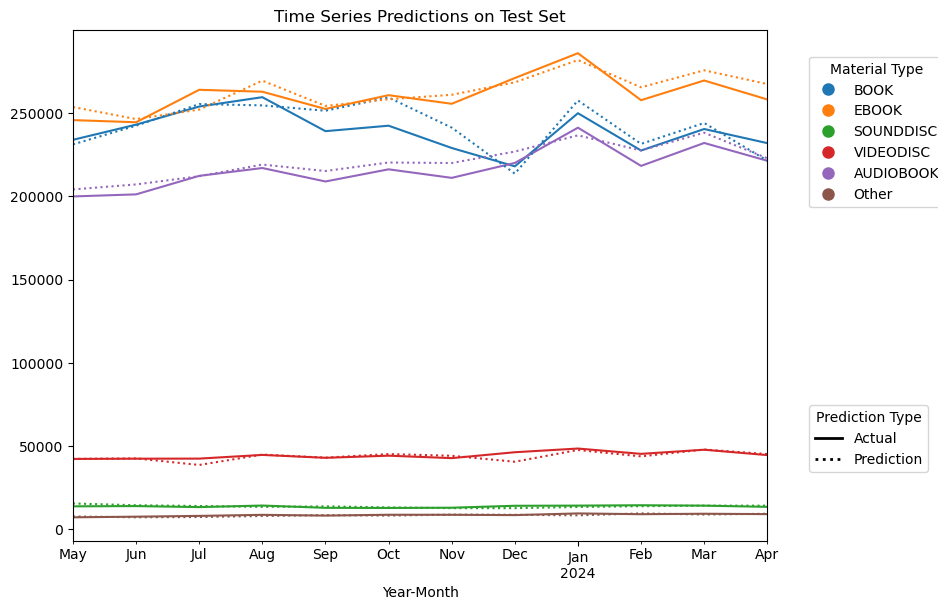

In [165]:
from matplotlib.lines import Line2D

df_end = df.iloc[217:]
df_test_preds_end= df_test_preds.iloc[217:]


# Define corresponding colors for materials
colors = dict(zip(materials, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']))

# Define linestyles for different prediction types
linestyles = {'Actual': '-', 'Prediction': ':'}

# Plot predictions with whole time series
fig, ax = plt.subplots(figsize=(12, 6))
df_end.plot(x='Year-Month', y=materials, color=colors, ax=ax)
df_test_preds_end.plot(x='Year-Month', y=materials, ls=linestyles['Prediction'], color=colors, ax=ax)


# Create custom legends
color_handles = [Line2D([0], [0], color=color, marker='o', markersize=8, linestyle='None') for color in colors.values()]
linestyle_handles = [Line2D([0], [0], color='black', linestyle=style, lw=2) for style in linestyles.values()]

# Add legends outside the plot
color_legend = ax.legend(handles=color_handles, labels=materials, title='Material Type', loc='center left', bbox_to_anchor=(1.05, 0.8))
ax.add_artist(color_legend)  # Add material type legend first
linestyle_legend = ax.legend(handles=linestyle_handles, labels=linestyles.keys(), title='Prediction Type', loc='center left', bbox_to_anchor=(1.05, 0.2))

# Adjust layout to make room for legends
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Reserve space for the legends on the right
plt.title('Time Series Predictions on Test Set')
plt.show()


In [166]:
df_test_errors=pd.DataFrame(index=[], columns=materials)
for feature in materials:
    df_test_errors.loc['RMSE',feature]=rmse(y_true=df.loc[217:228][feature], y_pred=df_test_preds.loc[217:228][feature])
    df_test_errors.loc['MAPE',feature]=mape(y_true=df.loc[217:228][feature], y_pred=df_test_preds.loc[217:228][feature])
    

In [167]:
df_test_errors.head()

,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
RMSE,8367.668882,6433.950623,856.238831,2114.353603,5684.05859,544.834837
MAPE,0.02854,0.021712,0.052908,0.028916,0.023206,0.05525
